In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy import optimize
import sys
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('./train.csv')
df_backup = df.copy()

# Introduce to the Features
 - ### Pclass: Ticket class
 - ### Sex: sex
 - ### Sex: 
    - #### 1 = Male 
    - #### 0 = Female
 - ### SibSp: Number of siblings/spouses aboard the Titanic
 - ### Parch: Number of parents/children aboard the Titanic
 - ### Ticket: Ticket number
 - ### Fare： Passenger fare
 - ### Cabin: Cabin number
 - ### Embarked: Port of Embarkation

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# drop PassengerID
df =df.drop('PassengerId', axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Processing Missing Data

In [7]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Cabin 
### -> Contain too much null value, We can just drop this column

In [8]:
df = df.drop('Cabin',axis=1)

## Embarked
### -> Too less missing value, we will just drop them or fill them fill the most frequent value

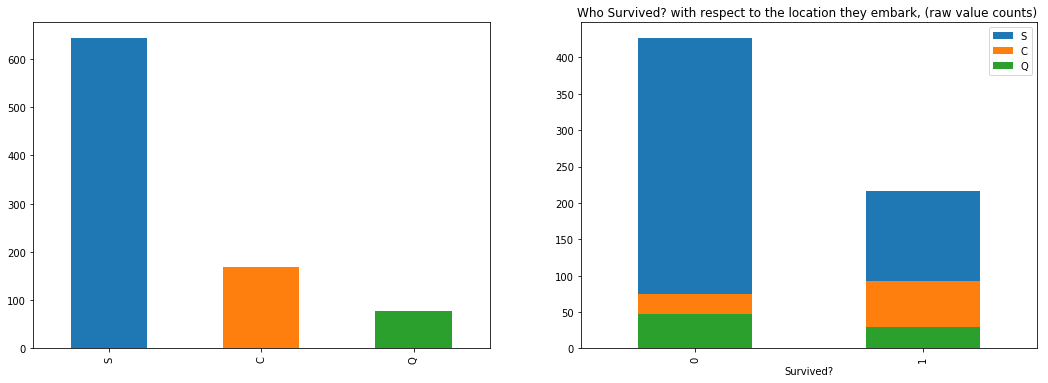

We can see the 'S' is the most frequent value


In [9]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
df.Embarked.value_counts().plot(kind='bar')

ax2 = fig.add_subplot(122)
df.Survived[df.Embarked == 'S'].value_counts().sort_index().plot(kind='bar', color='#1f77b4',label = 'S')
df.Survived[df.Embarked == 'C'].value_counts().sort_index().plot(kind='bar', color='#ff7f0e', label='C')
df.Survived[df.Embarked == 'Q'].value_counts().sort_index().plot(kind='bar', color='#2ca02c',label = 'Q')
plt.title("Who Survived? with respect to the location they embark, (raw value counts) ")
plt.xlabel('Survived?')
plt.legend(loc='best')
plt.savefig("Survival Embarked bar plt.png")
plt.show()
print('We can see the \'S\' is the most frequent value')

In [10]:
df.Embarked.fillna('S', inplace = True)

## Age
### -> It still have many available value, so we will use linear regression to fill the missing value
### BUT before that we have to preprocess the data

# Pre-processing

### Function convert to dummy feature

In [11]:
def convert_todummies(df,columnname):
    titles_dummies = pd.get_dummies(df[columnname], prefix=columnname)
    df = df.drop(columnname, axis=1)
    combined = pd.concat([df, titles_dummies], axis=1)
    return combined

## PClass and Embark: Convert it to Dummy Feature Matrics

In [12]:
df = convert_todummies(df, 'Pclass')
df = convert_todummies(df, 'Embarked')

## Sex : Convert to Dummy Feature -> Male or not

In [13]:
df['Sex'] = df['Sex'].map({'male':1, 'female':0})

## Name: drop? or more information? 
### -> We can see the name indicate the social status: Mr, Mrs... might contribute to our model, so we have to extract this name prefix

In [14]:
temp = df.values
for i in range(0, df.shape[0]):
    temp[i][1] = df.Name[i].split(',')[1].split('.')[0].strip()
df = pd.DataFrame(temp, columns=df.columns.tolist())

In [15]:
df.Name.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

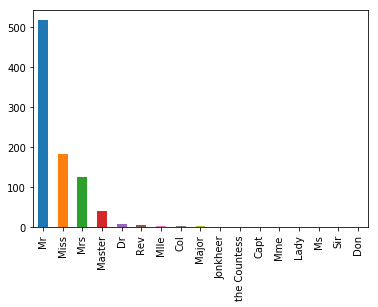

In [16]:
df.Name.value_counts().plot(kind='bar')
plt.savefig("Number of name prefix.png")
plt.show()

In [17]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Married",
    "Mlle": "Unmarried",
    "Ms": "UnKnow_Married",
    "Mr" : "UnKnow_Married",
    "Mrs" : "Married",
    "Miss" : "Unmarried",
    "Master" : "Young",
    "Lady" : "Royalty"
}

df.Name = df.Name.map(Title_Dictionary)

df = convert_todummies(df, 'Name')
cols = df.columns.tolist()

for i in range(0,len(cols)):
    col = cols[i]
    if len(col.split('_')) > 0:
        col = col.replace('Name_', '')
    cols[i] = col


df.columns = cols

In [18]:
df = df.drop('Ticket',axis=1)

In [19]:
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Married,Officer,Royalty,UnKnow_Married,Unmarried,Young
0,0,1,22,1,0,7.25,0,0,1,0,0,1,0,0,0,1,0,0
1,1,0,38,1,0,71.2833,1,0,0,1,0,0,1,0,0,0,0,0
2,1,0,26,0,0,7.925,0,0,1,0,0,1,0,0,0,0,1,0
3,1,0,35,1,0,53.1,1,0,0,0,0,1,1,0,0,0,0,0
4,0,1,35,0,0,8.05,0,0,1,0,0,1,0,0,0,1,0,0


In [20]:
cols = df.columns.tolist()

In [21]:
temp = df.values
for i in range(0, df.shape[0]):
    if temp[i][12] == 0 and temp[i][16] == 0 and temp[i][15] == 0:
        temp[i][15] == 1

df = pd.DataFrame(temp, columns=cols)

t = cols[2]
cols[2] = cols[1]
cols[1] = t
df=df.reindex(columns=cols)

df.head()

,Survived,Age,Sex,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Married,Officer,Royalty,UnKnow_Married,Unmarried,Young
0,0,22,1,1,0,7.25,0,0,1,0,0,1,0,0,0,1,0,0
1,1,38,0,1,0,71.2833,1,0,0,1,0,0,1,0,0,0,0,0
2,1,26,0,0,0,7.925,0,0,1,0,0,1,0,0,0,0,1,0
3,1,35,0,1,0,53.1,1,0,0,0,0,1,1,0,0,0,0,0
4,0,35,1,0,0,8.05,0,0,1,0,0,1,0,0,0,1,0,0


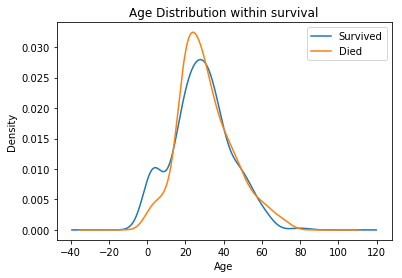

In [22]:
df.Age[df.Survived == 1].plot(kind='kde')    
df.Age[df.Survived == 0].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within survival")
# sets our legend for our graph.
plt.legend(('Survived', 'Died'),loc='best') 
plt.savefig("Age Distribution within survival.png")
plt.show()

In [23]:
age = df.iloc[:,1:]

# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# q = age.values.astype('float64')
# q[:,4] = sc.fit_transform(q[:,4].reshape(q.shape[0], 1)).reshape(q.shape[0],).astype(float)

#age = pd.DataFrame(q, columns=age.columns.tolist())
age_available =  age.dropna()

In [24]:
age.shape

(891, 17)

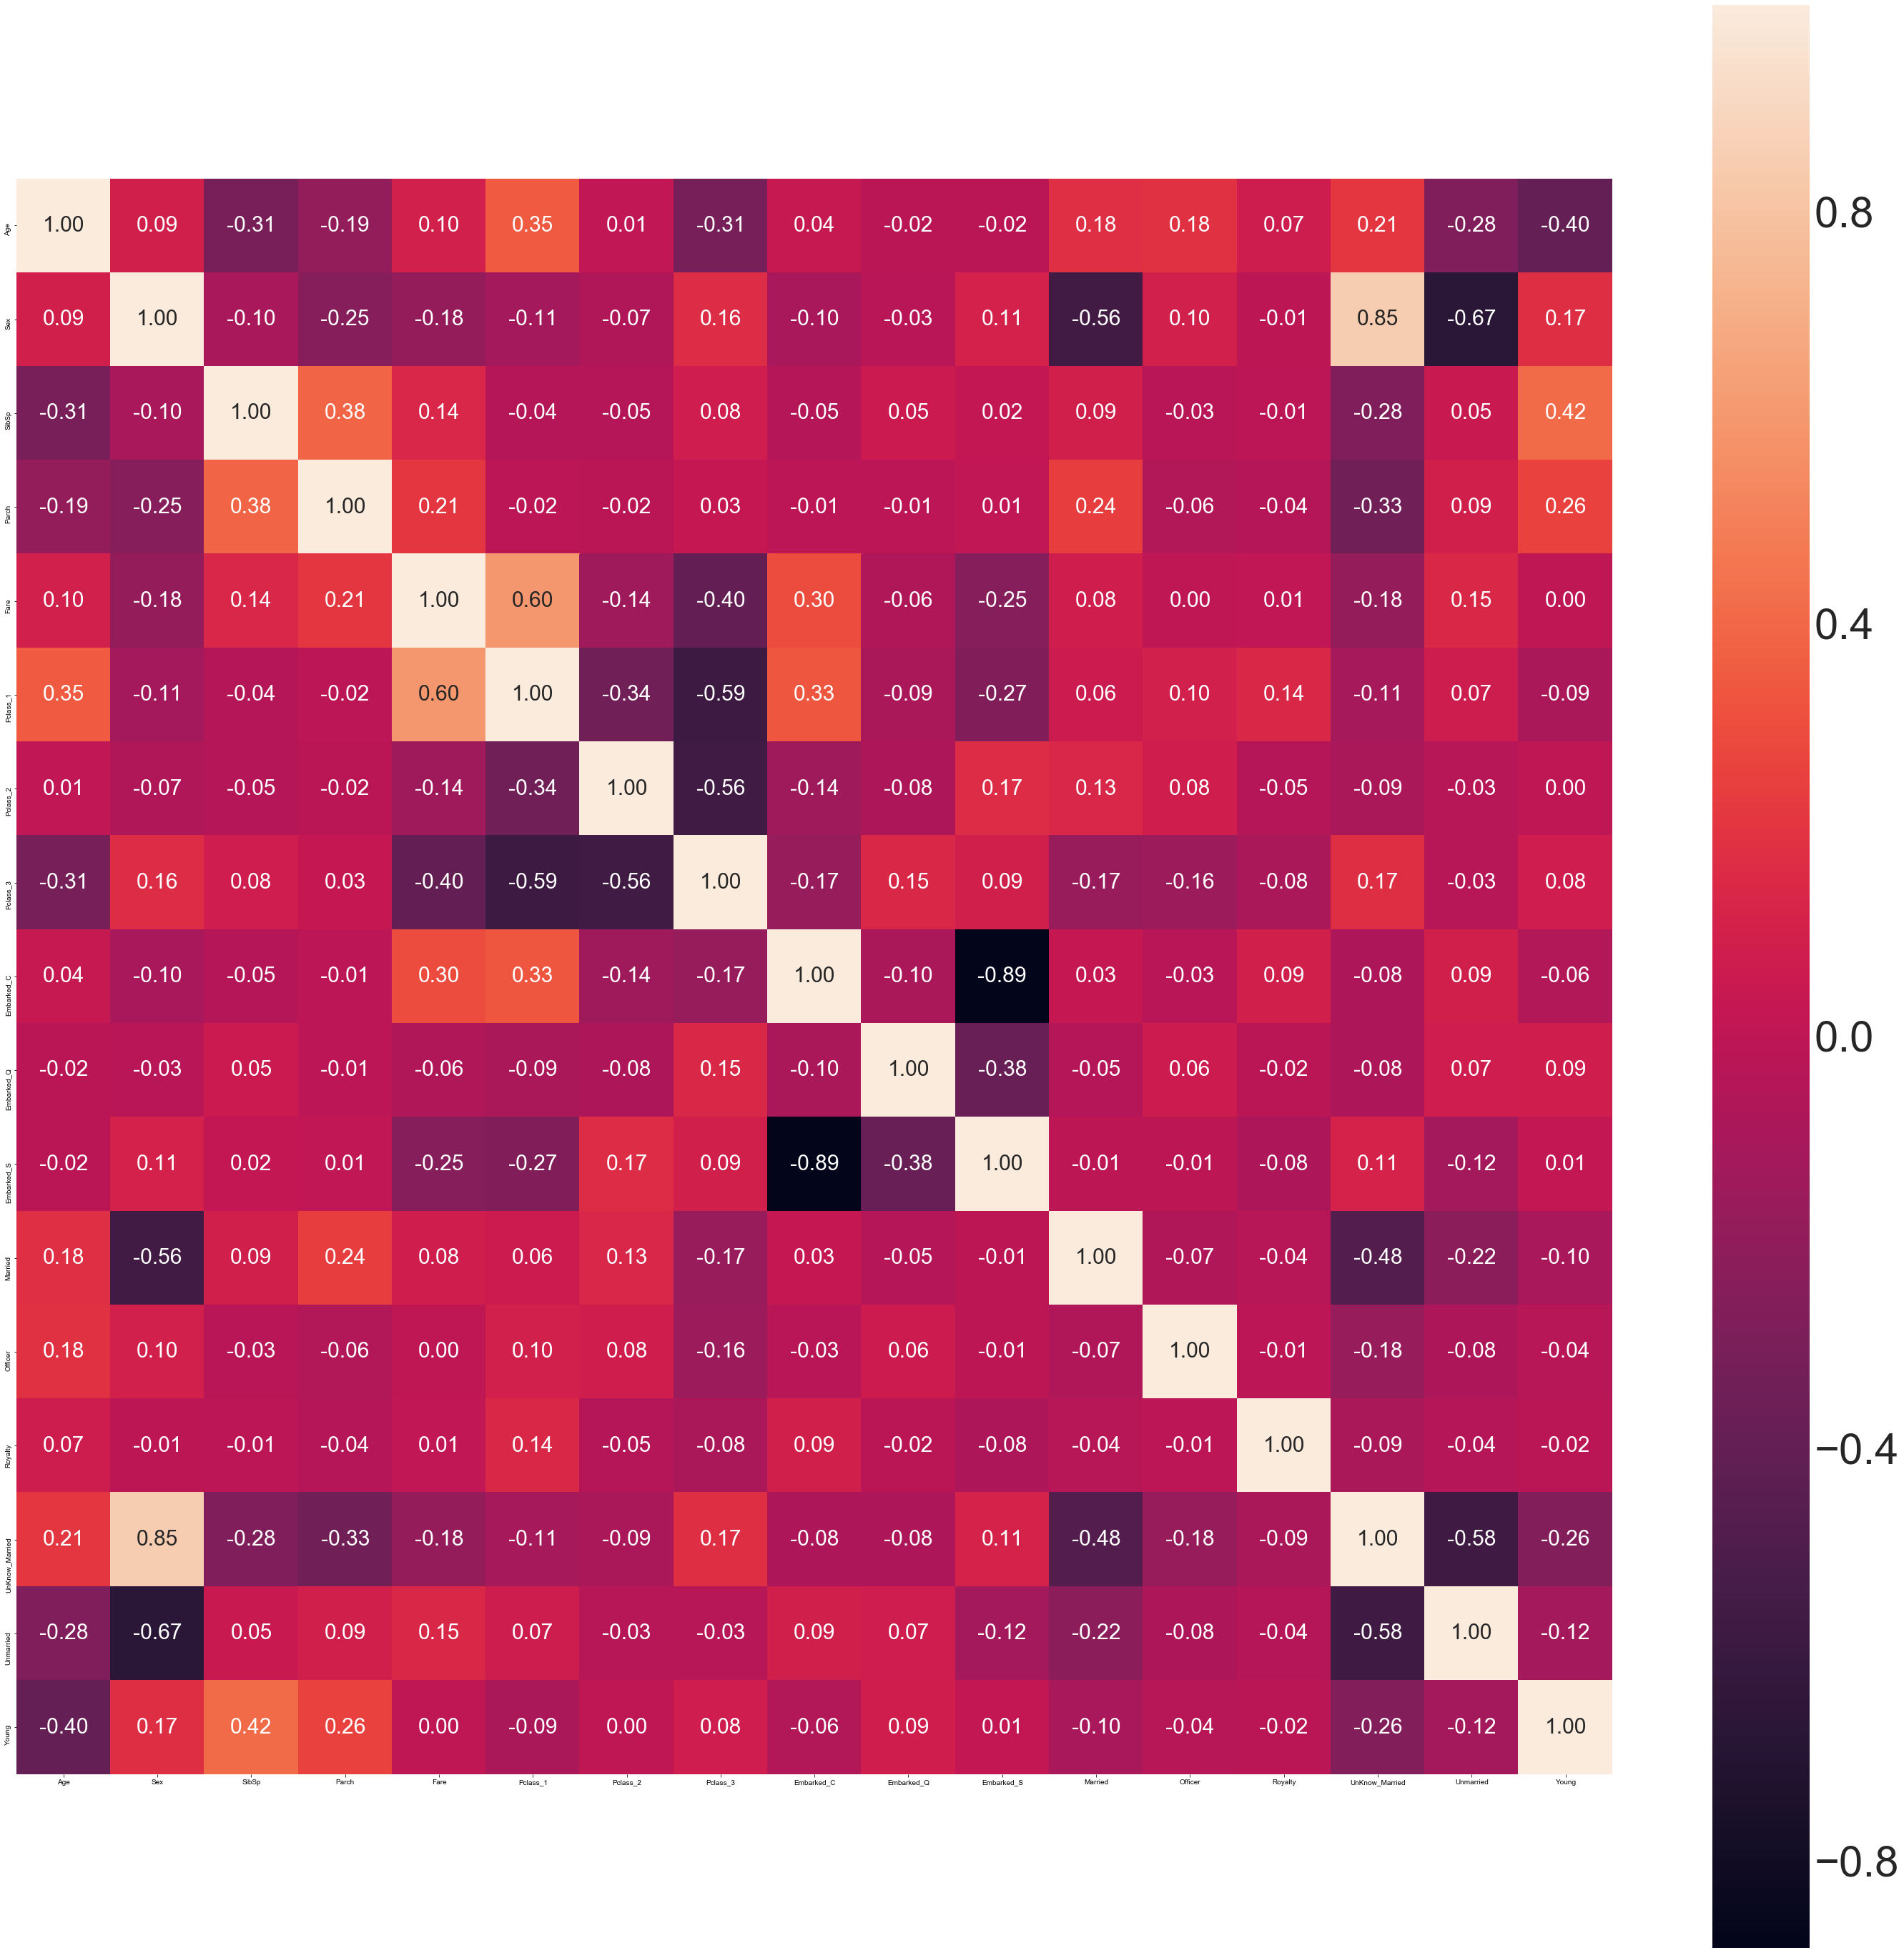

In [25]:
age_cols = age_available.columns
fig, ax = plt.subplots(figsize=(50,50))
sns.set(font_scale=6)
cm = np.corrcoef(age_available[age_cols].values.astype(np.float64).T)
hm = sns.heatmap(cm, cbar=True, annot=True,square=True, fmt='.2f', annot_kws={'size' : 30}, yticklabels=age_cols, xticklabels=age_cols)
plt.savefig("heatmap.png")
plt.show()

In [26]:
age_test_X = age.loc[age.isnull().any(axis=1)].iloc[:,1:]
age_test_y = age.loc[age.isnull().any(axis=1)].iloc[:,0]
age_available_X = age_available.iloc[:,1:]
age_available_y = age_available.iloc[:,0]

from sklearn.model_selection import train_test_split
age_train_X, age_cv_X, age_train_y, age_cv_y = train_test_split(age_available_X, age_available_y, test_size=0.3, random_state=0)


from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(age_train_X,age_train_y)

pred_age_cv = lr.predict(age_cv_X)
pred_age_train = lr.predict(age_train_X)

from sklearn.metrics import mean_squared_error

print('Mean square error: train = %f, test = %f'
      % (mean_squared_error(age_train_y,pred_age_train), mean_squared_error(age_cv_y,pred_age_cv)))

from sklearn.metrics import r2_score
print('R ^ 2            : train: %f, cv = %f' % ( r2_score(age_train_y,pred_age_train),r2_score(age_cv_y,pred_age_cv)) )

Mean square error: train = 117.108068, test = 131.152331
R ^ 2            : train: 0.439810, cv = 0.387608


In [27]:
from sklearn.preprocessing import PolynomialFeatures
quad = PolynomialFeatures(degree=2)
age_train_X_q = quad.fit_transform(age_train_X)
lr2 = LinearRegression()
lr2.fit(age_train_X_q, age_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
from sklearn.preprocessing import PolynomialFeatures
MSEtrain = []
MSEtest = []

quad = PolynomialFeatures(degree=2)
age_train_X_q = quad.fit_transform(age_train_X)
lr2 = LinearRegression()
lr2.fit(age_train_X_q, age_train_y)

pred_age_cv_q = lr2.predict(quad.fit_transform(age_cv_X))
pred_age_train_q = lr2.predict(age_train_X_q)

print('Mean square error: train = %f, test = %f'
      % (mean_squared_error(age_train_y,pred_age_train_q), mean_squared_error(age_cv_y,pred_age_cv_q)))
MSEtrain.append(mean_squared_error(age_train_y,pred_age_train_q))
MSEtest.append( mean_squared_error(age_cv_y,pred_age_cv_q))

print('R ^ 2            : train: %f, cv = %f' % ( r2_score(age_train_y,pred_age_train_q),r2_score(age_cv_y,pred_age_cv_q)) )

Mean square error: train = 99.118582, test = 2223.158826
R ^ 2            : train: 0.525863, cv = -9.380637


In [29]:
from sklearn.linear_model import Ridge
ridge =Ridge(alpha=10)

ridge.fit(age_train_X,age_train_y)

pred_age_cv = ridge.predict(age_cv_X)
pred_age_train = ridge.predict(age_train_X)

print('Mean square error: train = %f, test = %f'
      % (mean_squared_error(age_train_y,pred_age_train), mean_squared_error(age_cv_y,pred_age_cv)))

print('R ^ 2            : train: %f, cv = %f' % ( r2_score(age_train_y,pred_age_train),r2_score(age_cv_y,pred_age_cv)) )


Mean square error: train = 119.979015, test = 132.457160
R ^ 2            : train: 0.426077, cv = 0.381515


We can see that we cant not overcome the problem of overfitting<br>
might duo to less training example (because we have already try polynomial with different degree and add regulation term)

In [30]:
temp = df.values
cols = df.columns.tolist()
for i in range(0,df.shape[0]):
    if np.isnan(temp[i,1]):
        temp[i,1] = ridge.predict(temp[i,2:].reshape(1,16)).reshape(1,).round()[0]
df = pd.DataFrame(temp, columns=cols)

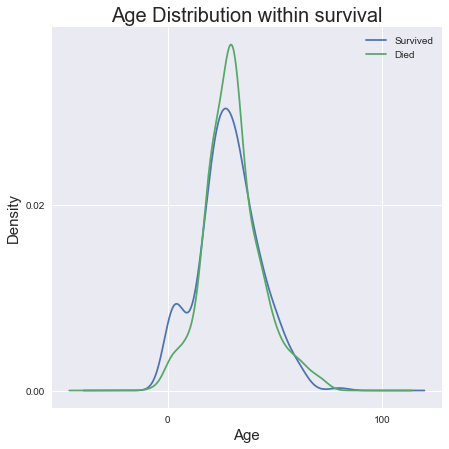

In [31]:
fig, ax = plt.subplots(figsize=(7,7))
df.Age[df.Survived == 1].plot(kind='kde')    
df.Age[df.Survived == 0].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age", size=15)    
plt.title("Age Distribution within survival", size=20)
plt.ylabel('Density',size=15)
# sets our legend for our graph.
plt.legend(('Survived', 'Died'),loc='best', prop={'size': 10}) 
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.savefig("ageDBeforeSurvival.png")
plt.show()

In [32]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values.astype(int)
X_train, X_cv,y_train, y_cv = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_backup = X_train.copy()
X_cv_backup = X_cv.copy()

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train.astype(float))
X_cv = stdsc.fit_transform(X_cv.astype(float))
 
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
y_pred = logr.predict(X_cv)
train_pred = logr.predict(X_train)

from sklearn.metrics import accuracy_score

print('Training Accuracy: %f' % accuracy_score(y_train, train_pred))
print('Cross-Validation Accuracy: %f' % accuracy_score(y_cv, y_pred))

Training Accuracy: 0.841091
Cross-Validation Accuracy: 0.820896


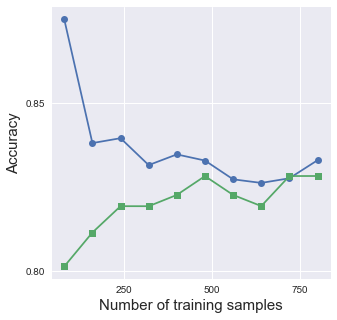

In [34]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=logr, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                        cv = 10,
                                                        n_jobs=1
                                                       )

train_scores_means = np.mean(train_scores, axis=1)
test_scores_means = np.mean(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(train_sizes, train_scores_means, label='Training Accuracy', marker='o')
plt.plot(train_sizes, test_scores_means, label='Cross-Validation Accuracy', marker='s')
plt.xlabel('Number of training samples', size=15)
plt.ylabel('Accuracy', size=15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.savefig("LogrLearningCurve.png")
plt.show()

### Overall, Logistic Regression work perfectly, let try tune another parameter

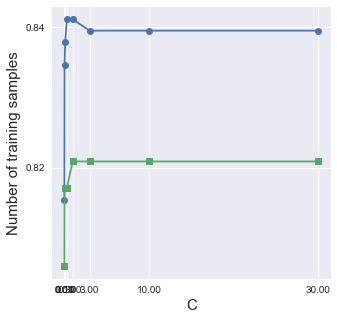

In [35]:
train_a, cv_a = [], []
index = [0.01,0.03,0.1,0.3, 1,3, 10, 30]
for c in index:
    model = LogisticRegression(C=c, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    train_pred = model.predict(X_train)
    train_a.append(accuracy_score(y_train, train_pred))
    cv_a.append(accuracy_score(y_cv, y_pred))

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.array(index), train_a, label='Training Accuracy', marker='o')
plt.plot(np.array(index), cv_a, label='Cross-Validation Accuracy', marker='s')
plt.ylabel('Number of training samples', size=15)
plt.xlabel('C', size=15)
ax.set_xticks(index)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.savefig("LearningCurveDiffC.png")
plt.show()

## As we can see this doesn't change much

# Let try Super Vector Machine(SVM)

In [36]:
from sklearn import svm

sv = svm.SVC(kernel='rbf', random_state=0)
sv.fit(X_train,y_train)

y_pred = sv.predict(X_cv)
train_pred = sv.predict(X_train)

from sklearn.metrics import accuracy_score

print('Training Accuracy: %f' % accuracy_score(y_train, train_pred))
print('Cross-Validation Accuracy: %f' % accuracy_score(y_cv, y_pred))

Training Accuracy: 0.847512
Cross-Validation Accuracy: 0.820896


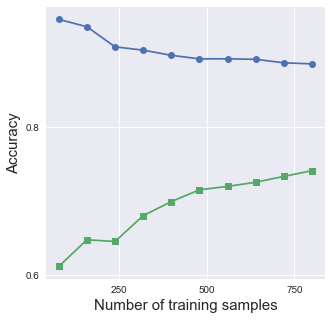

In [37]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=sv, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                        cv = 10,
                                                        n_jobs=1
                                                       )

train_scores_means = np.mean(train_scores, axis=1)
test_scores_means = np.mean(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(train_sizes, train_scores_means, label='Training Accuracy', marker='o')
plt.plot(train_sizes, test_scores_means, label='Cross-Validation Accuracy', marker='s')
plt.xlabel('Number of training samples', size=15)
plt.ylabel('Accuracy', size=15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.savefig("SVMLearningCurve.png")
plt.show()

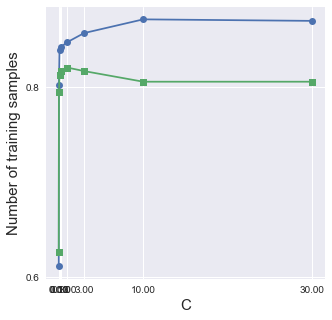

In [43]:
train_a, cv_a = [], []
index = [0.01,0.03,0.1,0.3, 1,3, 10, 30]
for c in index:
    model =svm.SVC(kernel='rbf', random_state=0, C=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    train_pred = model.predict(X_train)
    train_a.append(accuracy_score(y_train, train_pred))
    cv_a.append(accuracy_score(y_cv, y_pred))

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.array(index), train_a, label='Training Accuracy', marker='o')
plt.plot(np.array(index), cv_a, label='Cross-Validation Accuracy', marker='s')
plt.ylabel('Number of training samples', size=15)
plt.xlabel('C', size=15)
ax.set_xticks(index)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.savefig("SVMLearningCurveDiffC.png")
plt.show()

In [39]:
test = pd.read_csv('test.csv')

In [40]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [41]:
X_train[:,1]

array([ 0.72592065, -1.37756104,  0.72592065,  0.72592065, -1.37756104,
        0.72592065,  0.72592065,  0.72592065,  0.72592065,  0.72592065,
       -1.37756104, -1.37756104,  0.72592065, -1.37756104,  0.72592065,
       -1.37756104,  0.72592065,  0.72592065,  0.72592065, -1.37756104,
        0.72592065,  0.72592065,  0.72592065,  0.72592065, -1.37756104,
       -1.37756104, -1.37756104,  0.72592065,  0.72592065,  0.72592065,
        0.72592065,  0.72592065, -1.37756104,  0.72592065,  0.72592065,
        0.72592065,  0.72592065, -1.37756104,  0.72592065, -1.37756104,
       -1.37756104,  0.72592065,  0.72592065, -1.37756104, -1.37756104,
        0.72592065,  0.72592065,  0.72592065,  0.72592065,  0.72592065,
        0.72592065,  0.72592065,  0.72592065, -1.37756104, -1.37756104,
       -1.37756104,  0.72592065,  0.72592065,  0.72592065,  0.72592065,
        0.72592065,  0.72592065, -1.37756104,  0.72592065,  0.72592065,
        0.72592065,  0.72592065,  0.72592065,  0.72592065,  0.72